# Modélisation des séries temporelles avec LSTM : Cas pratique et implémentation

## 1. Introduction
Ce tutorial s'adresse aux debutants qui veulent monter en competence sur l'etude et la visualisation des données sequentielles. Nous allons utiliser des approches statistiques pour determiner quels modéle est mieu adapter au traitement du jeu de donnees. Dans ce tutoriels, nous apprenons les models ARIMA, SARIMA, SARIMAX et LSTM et comprendre leurs differences et leurs utilisations. 
nous analysons le dataset [Household Electric Power Consumption](https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set/data).

## 2. Exploration des Données (EDA)

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [25]:
print("The current repertory :", os.getcwd())

The current repertory : /home/kd/Desktop/DL_TimeSeries/tests


In [26]:
file_path = '../data/individual+household+electric+power+consumption/household_power_consumption.txt'
if os.path.exists(file_path):
    print("File found!")
else: 
    print("File NOT found, Check the path please!")

File found!


In [27]:

def read_file(file_path):
    df = pd.read_csv(file_path, sep=';', na_values='?', low_memory=False)

    # Fusionner Date et Time en datetime après chargement
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

    # Supprimer les colonnes originales (car elles sont maintenant dans datetime)
    df.drop(columns=['Date', 'Time'], inplace=True)

    df.set_index('datetime', inplace=True)  # Définir 'datetime' comme index
    df.sort_index(inplace=True)
    print(df.index.min(), df.index.max())

    return df

df = read_file(file_path)
df.head()

2006-12-16 17:24:00 2010-11-26 21:02:00


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [29]:
# Vérification des Valeurs Manquantes

missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [30]:
# Statistiques Deescriptives
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


L’analyse statistique descriptive nous donne un aperçu des valeurs centrales, des dispersions et des extrêmes pour chaque variable du dataset Household Power Consumption.
- ***Global Active Power***
    - Moyenne (mean) : 1.09 kW → La consommation électrique moyenne est d'environ 1 kW.
    - Min & Max : 0.076 kW à 11.12 kW → La consommation varie fortement, avec des pics élevés.
    - Écart-type (std) : 1.06 kW → Forte dispersion, ce qui indique que la consommation fluctue beaucoup.
    - Distribution : La médiane (50%) est 0.6 kW, ce qui montre que la majorité des valeurs sont inférieures à la moyenne (distribution asymétrique à droite).
    - Valeurs extrêmes (outliers) : Des pics jusqu'à 11.12 kW indiquent des périodes de consommation très élevée
- ***Global Reactive Power***
    - Moyenne : 0.12 kW → Relativement faible, ce qui est normal car la puissance réactive est l’énergie non consommée (pertes).
    - Écart-type : 0.11 kW → Variation significative, bien que les valeurs restent faibles.
    - Max : 1.39 kW → Certaines périodes présentent des pertes électriques importantes.
- ***Voltage***
    - Moyenne : 240.8 V, avec un écart-type de 3.2 V → La tension est stable, centrée autour de la valeur standard de 240 V.
    - Min & Max : 223.2 V à 254.1 V → Quelques fluctuations, mais dans une plage acceptable.
- ***Global Intensity***
    - Moyenne : 4.62 A, avec une médiane de 2.6 A → L’intensité consommée est généralement faible.
    - Max : 48.4 A → Certains appareils gourmands en énergie peuvent provoquer des pics.

array([[<Axes: title={'center': 'Global_active_power'}>,
        <Axes: title={'center': 'Global_reactive_power'}>,
        <Axes: title={'center': 'Voltage'}>],
       [<Axes: title={'center': 'Global_intensity'}>,
        <Axes: title={'center': 'Sub_metering_1'}>,
        <Axes: title={'center': 'Sub_metering_2'}>],
       [<Axes: title={'center': 'Sub_metering_3'}>, <Axes: >, <Axes: >]],
      dtype=object)

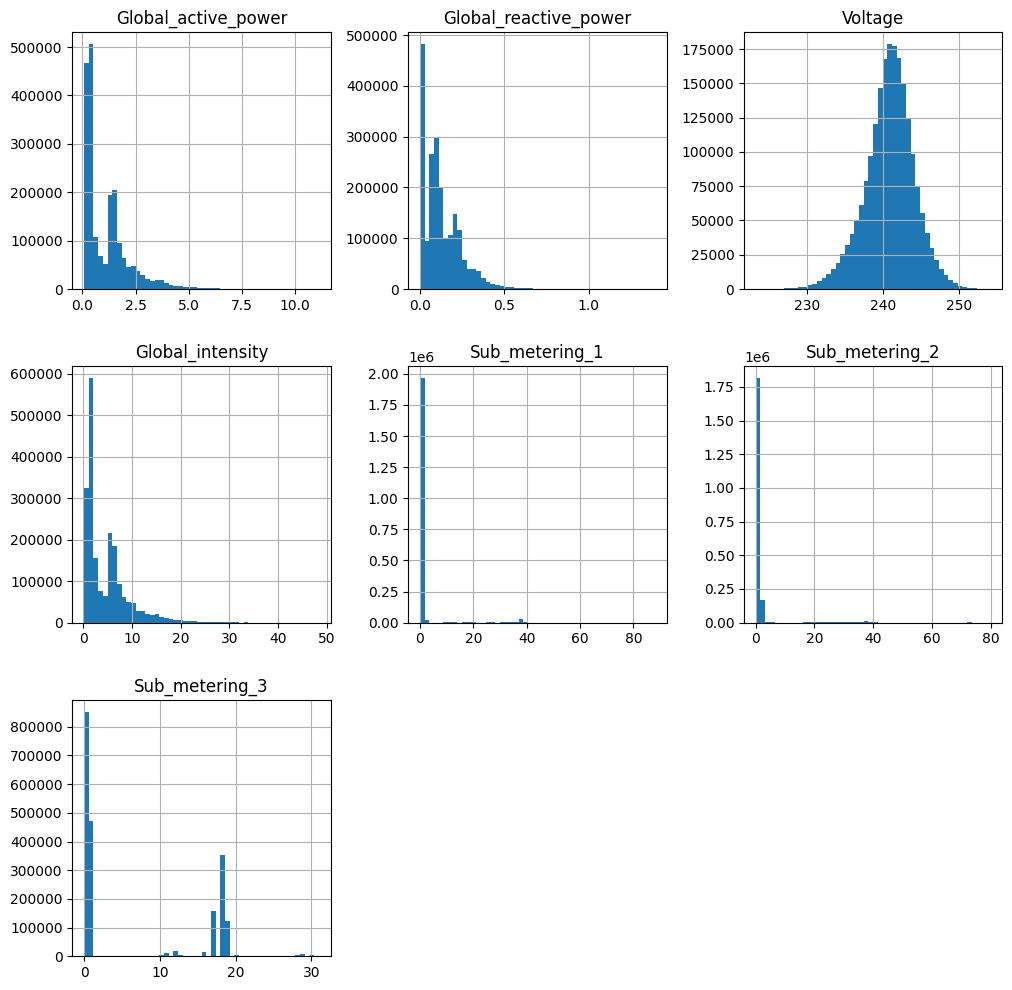

In [31]:
# Visualisation des Distributions

df[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].hist(bins=50, figsize=(12, 12))

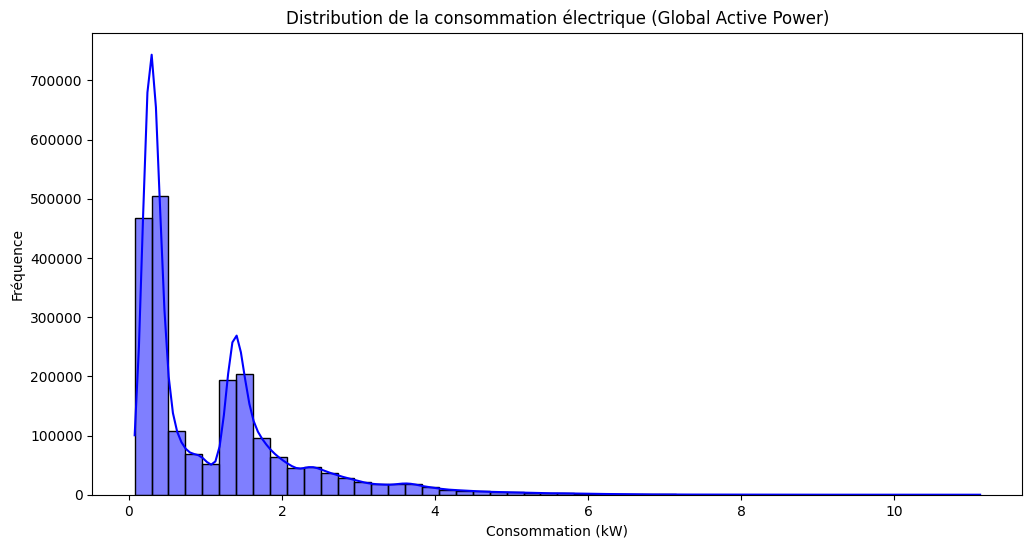

In [32]:
plt.figure(figsize=(12,6))
sns.histplot(df['Global_active_power'], kde=True, bins=50, color='blue')
plt.title("Distribution de la consommation électrique (Global Active Power)")
plt.xlabel("Consommation (kW)")
plt.ylabel("Fréquence")
plt.show()

Le graph ci-dessus permet d'examiner la distribution des différentes variables du dataset Household Power Consumption.

- ***Global Active Power*** est fortement asymétrique à droite  ce qui indique que la plupart des valeurs sont inférieur à (< 2 kW), mais qu’il existe des valeurs plus élevées jusqu’à environ 10 kW.
    - On observe deux pics distincts autour de 0.5 kW et 1.5 kW, ce qui peut suggérer des cycles d'utilisation d'appareils électriques.

- ***Voltage***  suit une courbe normale (distribution gaussienne) centrée autour de 240 V, ce qui est cohérent avec une alimentation électrique standard.
    - Les fluctuations sont comprises entre 225 V et 255 V.
    - La présence d'une symétrie suggère que la tension électrique reste stable la plupart du temps.

- ***Global Intensity*** suit une distribution similaire à la puissance active globale, car elle est directement liée à la consommation électrique (puissance = tension × intensité).
    - La majorité des valeurs sont faibles (< 10 A), mais il existe quelques valeurs plus élevées allant jusqu'à 50 A.
- ***Sub_metering_1 et Sub_metering_2*** : On obseve que la majorité des valeurs sont proches de 0, indiquant que cette sous-mesure ne capture de l’énergie que dans certaines périodes spécifiques.
- ***Sub_metering_3*** On observe trois pics distincts ce qui peut être lié à des variations de consommation en fonction des saisons.


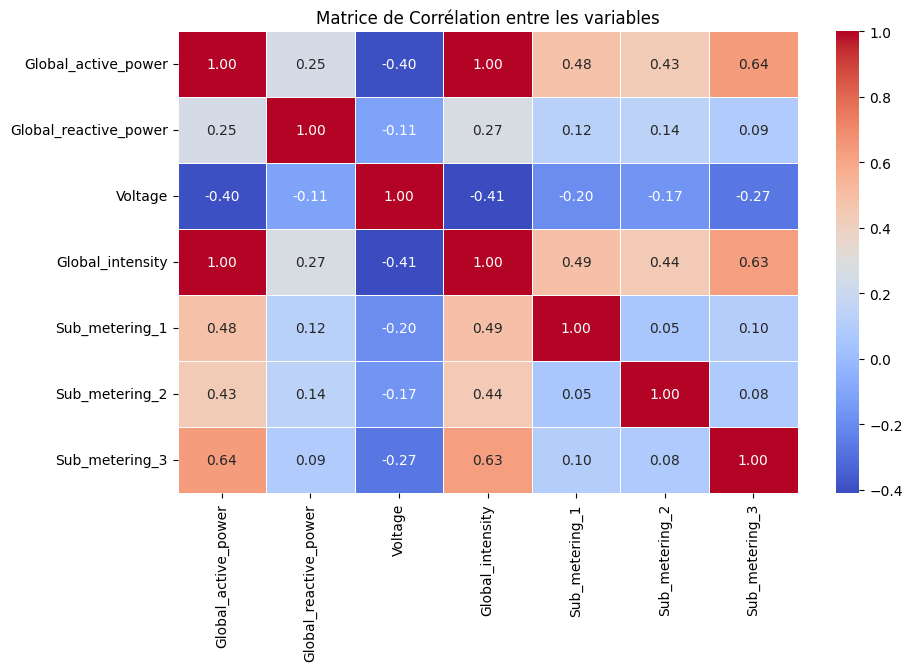

In [33]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation entre les variables")
plt.show()


Ce heatmap de corrélation permet de visualiser les relations entre les variables du dataset. Cette matrice nous aide à identifier les variables pertinentes pour prédire la consommation.
- ***Variables fortement corrélées***
    - **Global_active_power et Global_intensity (+1.00)**: l'intensité électrique est directement liée à la puissance consommée.
    - **Global_active_power et Sub_metering_3 (+0.64)**: la consommation mesurée par le compteur 3 contribue fortement à la consommation totale.
    - **Global_intensity et Sub_metering_3 (+0.63)**: Une hausse de l'intensité est souvent associée à une augmentation de la consommation de ce compteur.
- ***Variables avec une corrélation négative***
    - **Voltage et Global_active_power (-0.40)** : lorsque la puissance consommée augmente, la tension a tendance à baisser.
    - **Voltage et Global_intensity (-0.41)**: plus l’intensité augmente, plus la tension baisse, ce qui peut être dû à une chute de tension provoquée par une forte demande.
- ***Variables faiblement corrélées***
    - **Global_reactive_power** a une faible corrélation avec la puissance active (0.25).
    - **L'heure (hour)** n'a qu'une légère influence sur la consommation (0.28 avec Global_active_power).
    - **Les Sub_metering 1 & 2** sont peu corrélés aux autres variables, suggérant qu’ils mesurent des équipements spécifiques.
    
La tension et l’intensité influencent directement la puissance consommée.
Les sous-compteurs ont un impact inégal, suggérant des usages différents.


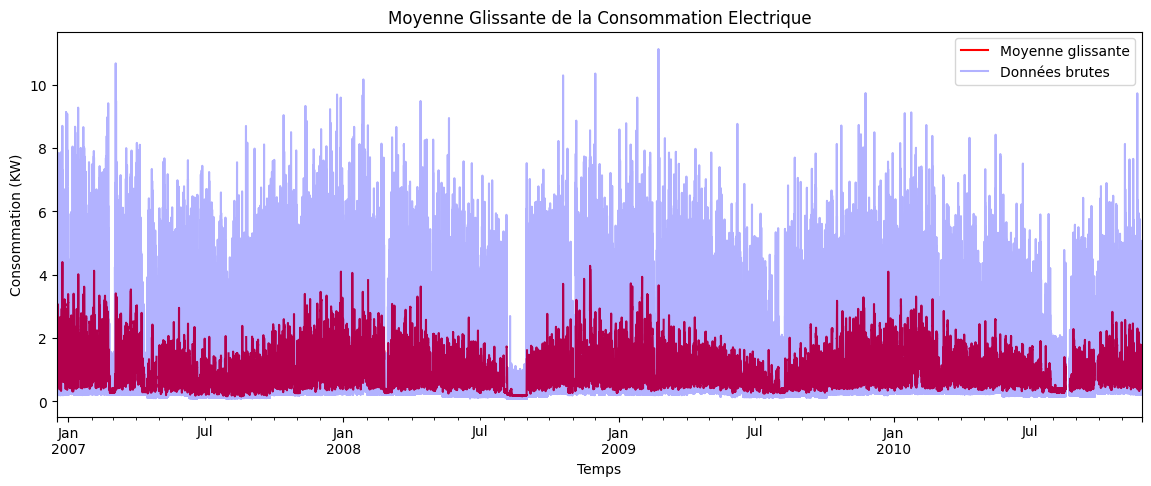

In [34]:
plt.figure(figsize=(14, 5))

# Utiliser directement df.index au lieu de df.set_index('datetime')
df['Global_active_power'].rolling(window=500).mean().plot(label='Moyenne glissante', color='red')
df['Global_active_power'].plot(alpha=0.3, label="Données brutes", color='blue')

plt.legend()
plt.title("Moyenne Glissante de la Consommation Electrique")
plt.xlabel("Temps")
plt.ylabel("Consommation (KW)")
plt.show()


Nous essayons d'analyser les tendances de consommation électrique au fil du temps en utilisant une moyenne glissante.
- ***Données brutes (en bleu clair)***:
    - La série temporelle montre une forte variabilité avec des pics fréquents.
    - On observe des périodes de consommation plus élevée que d'autres.
    - Des variations saisonnières peuvent être identifiées, avec des cycles récurrents.
- ***Moyenne glissante (en rouge foncé)***:
    - Elle permet de lisser les fluctuations en révélant la tendance générale de la consommation.
    - On remarque une tendance à la hausse et des variations cycliques
    - La consommation semble légèrement plus élevée en hiver.


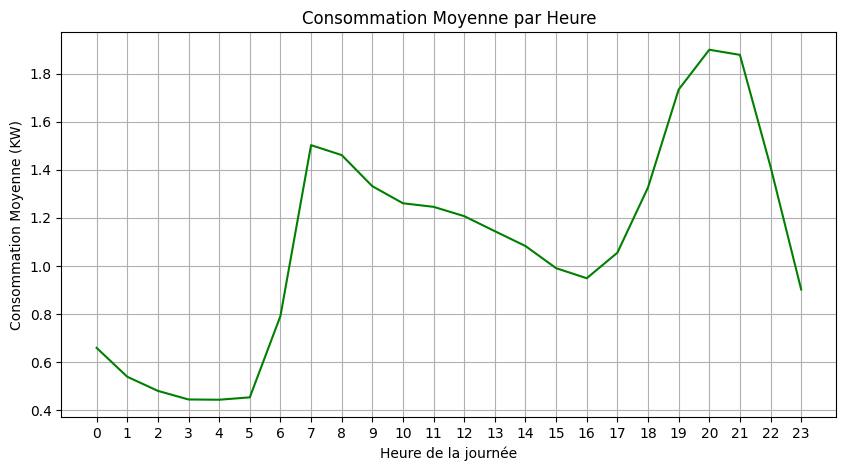

In [35]:
# Saisonnière - Moyenne par Heure

df['hour'] = df.index.hour  # Utilisation de l'index directement
hourly_avg = df.groupby('hour')['Global_active_power'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values, markers='o', color='green')
plt.title("Consommation Moyenne par Heure")
plt.xlabel("Heure de la journée")
plt.ylabel("Consommation Moyenne (KW)")
plt.xticks(range(0, 24))
plt.grid()
plt.show()


Ce graphique montre la moyenne de la consommation électrique en fonction de l’heure de la journée.
- ***Consommation basse pendant la nuit (0h - 5h)***:
    - La consommation commence faible aux alentours de 0.6 kW.
    - Elle atteint son point le plus bas entre 3h et 5h (environ 0.4 kW), ce qui est cohérent avec le fait que la plupart des appareils sont éteints durant cette période.
- ***Forte augmentation entre 6h et 8h*** :
    - Vers 6h, on observe un pic brutal, atteignant environ 1.5 kW à 7h - 8h. Cela correspond aux activités du matin : éclairage, préparation du petit déjeuner, chauffage, électroménagers.
- ***Stabilisation en journée (10h - 16h)*** :
La consommation baisse légèrement après 8h et atteint 0.9 kW au alentours de 16h pendant la journée.
Cette stabilité peut être due à des appareils en veille ou au travail à domicile.
- ***Nouveau pic en soirée (18h - 21h)*** :
    - À 18h, la consommation commence à remonter fortement. Elle culmine entre 20h et 21h avec une valeur proche de 1.9 kW.
    Ce pic est probablement lié aux activités du soir : retour à la maison, préparation du dîner, télévision, chauffage, éclairage.

- ***Forte baisse après 22h*** :
La consommation chute après 22h, indiquant une réduction des activités domestiques avant la nuit.


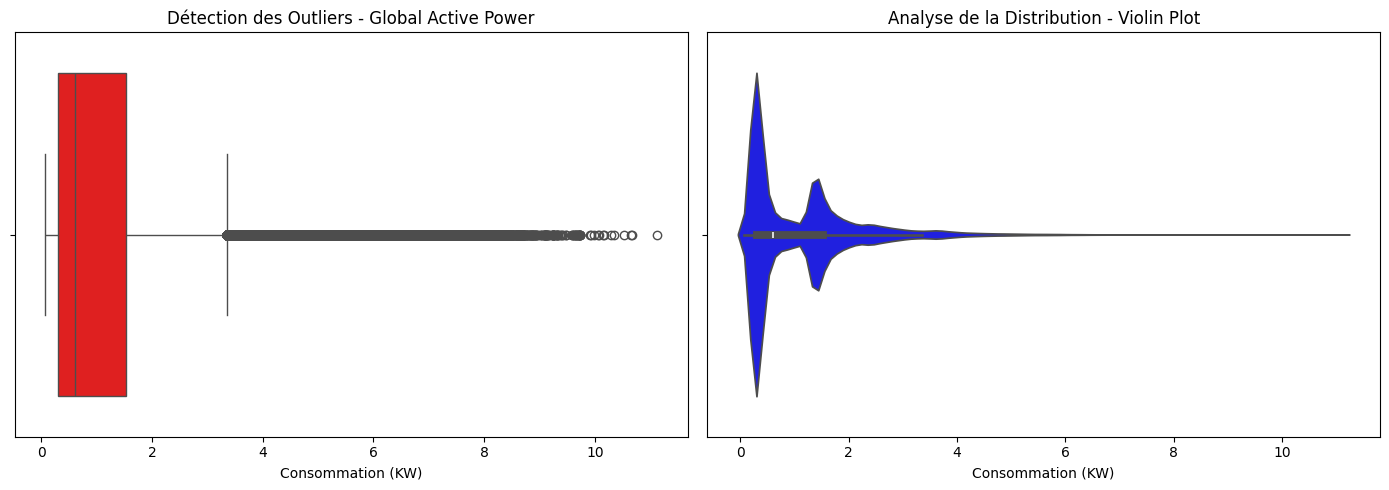

In [36]:
# Création de la figure avec deux sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot pour la détection des outliers
sns.boxplot(x=df['Global_active_power'], color='red', ax=axes[0])
axes[0].set_title("Détection des Outliers - Global Active Power")
axes[0].set_xlabel("Consommation (KW)")

# Violin Plot pour l'analyse de la distribution
sns.violinplot(x=df['Global_active_power'], color='blue', ax=axes[1])
axes[1].set_title("Analyse de la Distribution - Violin Plot")
axes[1].set_xlabel("Consommation (KW)")

# Affichage du graphe
plt.tight_layout()
plt.show()


Le graphique ci-dessus affiche à gauche un boxplot et à droite un violin plot pour analyser la distribution et détecter les valeurs aberrantes de la consommation électrique (Global Active Power).
- ***Boxplot (Gauche)***
    - Le rectangle rouge représente l’intervalle interquartile (IQR), qui couvre 50% des valeurs.
    - La ligne centrale indique la médiane, et les "moustaches" étendent les données jusqu'à 1.5 fois l'IQR.
    - Les points au-delà des moustaches sont considérés comme des outliers (valeurs extrêmes).
    - Il semble y avoir de nombreuses valeurs extrêmes au-dessus du maximum attendu.
- ***Violin Plot (Droite)***
    - Il montre une version lissée de l’histogramme pour visualiser la densité des valeurs.
    On remarque une concentration des données autour des faibles valeurs de consommation entre 0 et 2 kW.
    Une forte densité autour de 1 kW, ce qui signifie que cette consommation est courante
  
Contrairement au boxplot, le violin plot montre comment les valeurs sont réparties.

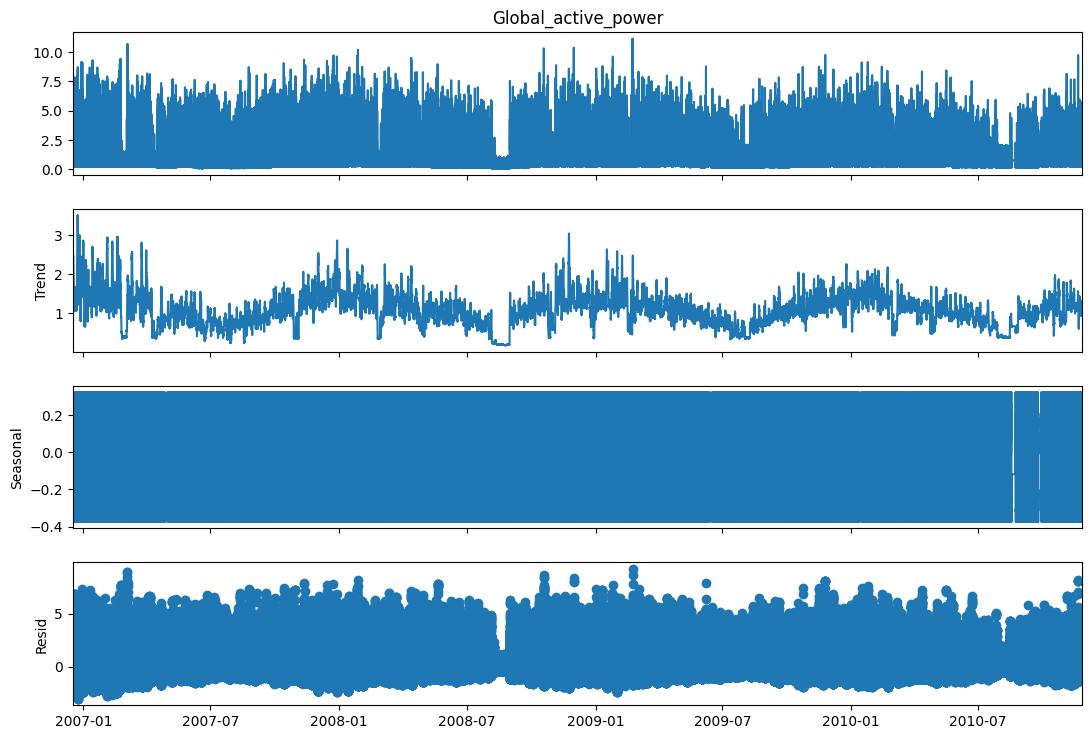

In [37]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

df = df.dropna(subset=['Global_active_power'])  # Supprime les valeurs NaN
decomposition = seasonal_decompose(df['Global_active_power'], period=1440)  # 1440 minutes = 1 jour

# Affichage propre du graphique
fig = decomposition.plot()
fig.set_size_inches(12, 8)  # Ajuste la taille du graphique
plt.show()


Le graphique affiche la décomposition saisonnière de la série temporelle Global_active_power.

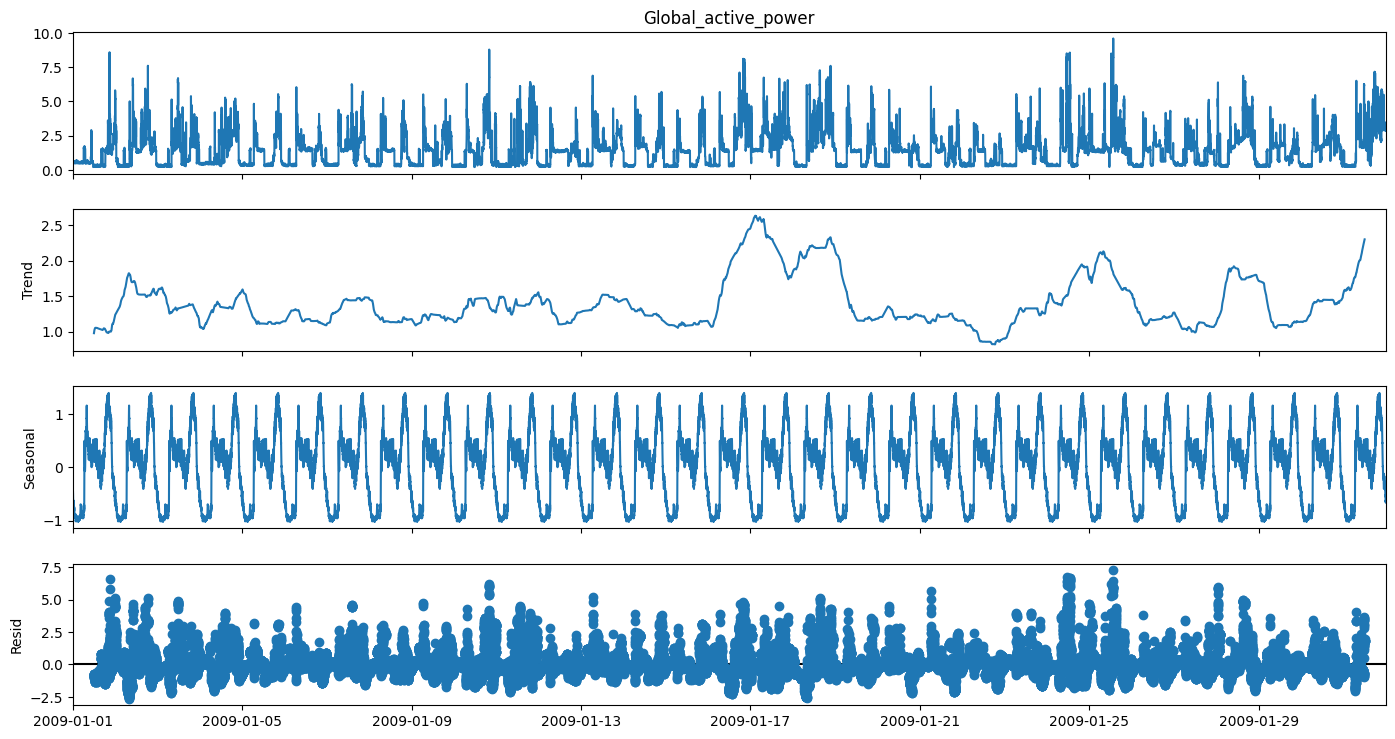

In [38]:
df_sample = df.loc['2009-01-01':'2009-01-31']
decomposition = seasonal_decompose(df_sample['Global_active_power'], period=1440)  # 1 jour
# Affichage propre du graphique
fig = decomposition.plot()
fig.set_size_inches(15, 8)  # Ajuste la taille du graphique
plt.show()


Ce graphique représente la décomposition de la série temporelle pour la consommation électrique (Global_active_power) sur un mois complet en janvier 2009.
- ***Série Originale (Global_active_power)***
    - On observe d’importantes variations de la consommation électrique.
    - Les pics sont réguliers, souvent associés aux moments de forte activité dans la journée (ex. matin et soir).
    - On remarque aussi des périodes de consommation très faible, probablement la nuit.
- ***Tendance (Trend)***
    - La tendance générale montre une évolution progressive de la consommation.
    Il y a une hausse autour du 15 janvier et une diminution est visible autour du 19 janvier.
- ***Saisonnalité (Seasonal)***
    - La saisonnalité est bien marquée avec un cycle de 24 heures.
    - Cela correspond aux habitudes quotidiennes des utilisateurs : forte consommation le matin et le soir.
    - Ce comportement répétitif confirme l'influence des rythmes de vie.
- ***Résidus (Resid)***
    - Ces résidus représentent la partie imprévisible de la série.
    - On observe des variations importantes, ce qui suggère des anomalies ponctuelles.
    - Ces pics aléatoires pourraient être causés par des événements exceptionnels (ex. équipements activés de manière irrégulière).

- ***Test de Stationnarité Dickey-Fuller (adfuller)***
Le test de Dickey-Fuller Augmenté (ADF) vérifie si une série temporelle est stationnaire ou non stationnaire.

    - **Hypothèse nulle (H0)** : La série a une racine unitaire, donc elle n'est pas stationnaire (elle suit une tendance).
    - **Hypothèse alternative (H1)** : La série est stationnaire

- ***Règle de Décision***
    - Si p-value < 0.05 → Rejet de H0 → La série est stationnaire
    - Si p-value ≥ 0.05 → On ne rejette pas H0 → La série n'est pas stationnaire

In [39]:
from statsmodels.tsa.stattools import adfuller
sample_size = 100_000  # Prendre un sous-échantillon de 100 000 points
df_sample = df['Global_active_power'].dropna().iloc[:sample_size]
result = adfuller(df_sample)
print(f"p-value: {result[1]}")

p-value: 3.52566982145228e-29


Une p-value très faible (3.52 × 10⁻²⁹, soit pratiquement 0) indique que l'hypothèse nulle (H0) est rejetée donc la série Global_active_power est stationnaire ! 

- Une série stationnaire a :

    - Une moyenne constante au fil du temps.
    - Une variance constante.
    - Une autocorrélation constante.

Si une série est stationnaire, elle est plus facile à modéliser avec des méthodes comme ARIMA, LSTM, etc

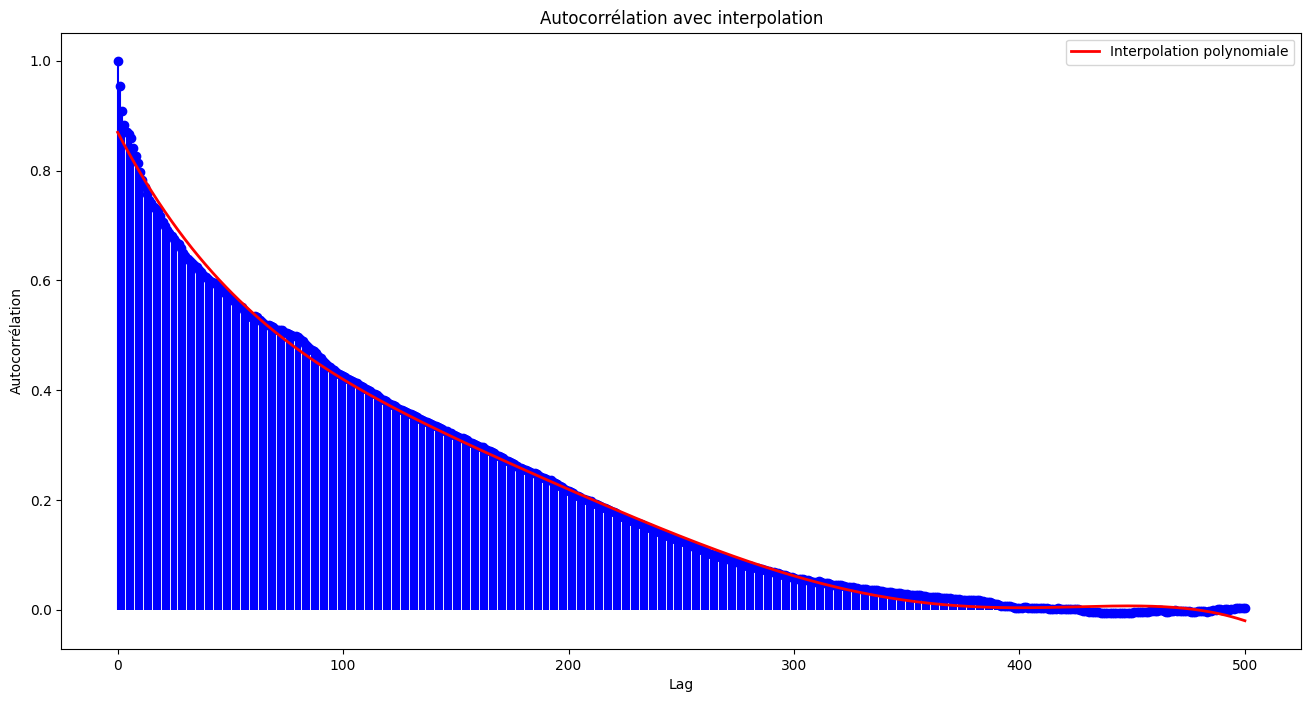

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Calculer l'ACF
from statsmodels.tsa.stattools import acf

lags = 500# Nombre de lags à afficher
acf_values = acf(df_sample, nlags=lags)

# Interpolation avec une régression polynomiale
x = np.arange(len(acf_values))
poly_coeffs = np.polyfit(x, acf_values, deg=5)  # Ajustement polynomial degré 5
poly_fit = np.polyval(poly_coeffs, x)

# Tracer l'ACF et l'interpolation
plt.figure(figsize=(16,8))
plt.stem(x, acf_values, linefmt='b-', markerfmt='bo', basefmt=" ")
plt.plot(x, poly_fit, 'r-', label="Interpolation polynomiale", linewidth=2)
plt.xlabel("Lag")
plt.ylabel("Autocorrélation")
plt.title("Autocorrélation avec interpolation")
plt.legend()
plt.show()


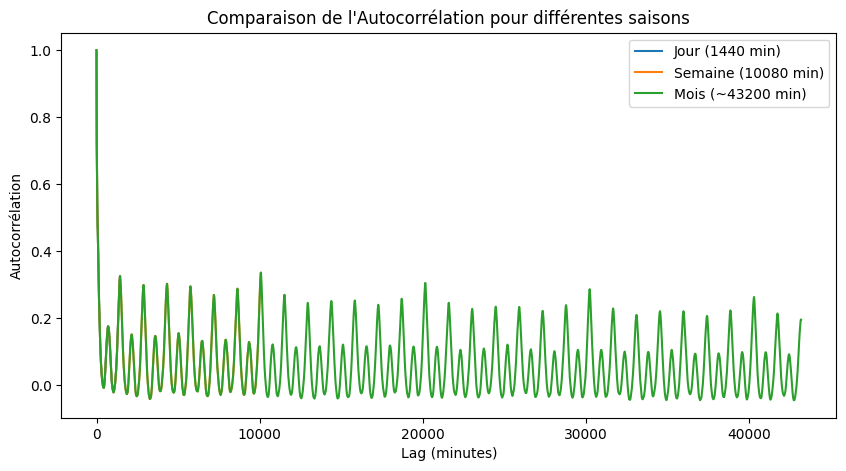

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Définition des périodes
lags_dict = {
    "Jour (1440 min)": 1440,
    "Semaine (10080 min)": 10080,
    "Mois (~43200 min)": 43200
}

plt.figure(figsize=(10, 5))

# Calcul et affichage de l'ACF pour chaque période
for label, nlags in lags_dict.items():
    acf_values = acf(df['Global_active_power'].dropna(), nlags=nlags)
    x = np.arange(len(acf_values))
    plt.plot(x, acf_values, label=label)

plt.xlabel("Lag (minutes)")
plt.ylabel("Autocorrélation")
plt.title("Comparaison de l'Autocorrélation pour différentes saisons")
plt.legend()
plt.show()


Le graphique montre l'autocorrélation de la consommation électrique avec interpolation polynomiale.



## 2. ARIMA (AutoRegressive Integrated Moving Average) 

ARIMA est un modèle statistique utilisé pour analyser et prévoir des séries chronologiques. Il repose sur trois composants principaux : l'**auto-régression (AR)**, l'**intégration (I)** et la **moyenne mobile (MA)**.  
Les modèles ARIMA visent à décrire les **auto-corrélations** dans les données.

### 🔹 Stationnarisation du processus avant modélisation ARMA

Dans le cas où le processus **$(X_t)_{t \in \mathbb{Z}}$** n'est **pas stationnaire**, il est nécessaire de le **stationnariser** avant de pouvoir l'analyser à l'aide d'un modèle **ARMA(p, q)**.

La stationnarisation permet de garantir que les propriétés statistiques du processus, telles que **la moyenne et la variance**, restent constantes dans le temps. Cette étape est essentielle pour assurer la validité des prédictions et l'ajustement correct du modèle.


### 🔹 Définition du modèle ARMA(p,q)

Un modèle **AutoRégressif et Moyenne-Mobile** d'ordres $(p,q)$ (**ARMA(p,q)**) est un **processus temporel discret** $(X_t, t \in \mathbb{N})$ vérifiant :

$$
X_t = \varepsilon_t + \sum_{i=1}^{p} \varphi_i X_{t-i} + \sum_{i=1}^{q} \theta_i \varepsilon_{t-i}
$$

où :
- $\varphi_i$ sont les **paramètres auto-régressifs** du modèle (**AR(p)**).
- $\theta_i$ sont les **paramètres de la moyenne mobile** (**MA(q)**).
- $\varepsilon_t$ est un **bruit blanc** (terme d'erreur aléatoire).


### 🔹 Cas particuliers :
- Un **modèle autorégressif** **AR(p)** est un **ARMA(p,0)** :
  
  $$
  X_t = \sum_{i=1}^{p} \varphi_i X_{t-i} + \varepsilon_t
  $$

- Un **modèle moyenne mobile** **MA(q)** est un **ARMA(0,q)** :

  $$
  X_t = \varepsilon_t + \sum_{i=1}^{q} \theta_i \varepsilon_{t-i}
  $$

### 🔹Remarque: 
Le processus ARMA n'est bien défini que s'il est stationnaire.

### 🔹 Modèle Auto-Régressif (AR)

AR est utilisé pour décrire la relation entre la valeur actuelle et les valeurs passées. Un modèle [**AR(p)**](https://fr.wikipedia.org/wiki/Processus_autor%C3%A9gressif) est défini par :

$$
X_t = \sum_{i=1}^{p} \varphi_i X_{t-i} + \varepsilon_t
$$
$$
X_t = \varphi_1 X_{t-1} + \varphi_2 X_{t-2} + ... + \varphi_p X_{t-p} + \epsilon_t
$$

où : 

$
\varphi_i \quad \text{sont les coefficients du modèle auto-régressif.} 
$

$
X_t \quad \text{est la valeur actuelle de la série temporelle.}
$

$
\epsilon_t \quad \text{est un bruit blanc.}
$

### 🔹 Composante Moyenne Mobile (MA)

Si $\epsilon_t$ n'est pas une séquence de bruit blanc, elle est généralement considérée comme une moyenne mobile **(MA)** d'ordre $q$.



Un modèle [**MA(q)**](https://fr.wikipedia.org/wiki/ARMA) est défini comme suit :

$$
X_t = \mu + \varepsilon_t + \sum_{i=1}^{q} \theta_i \varepsilon_{t-i}
$$

$$
X_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q}
$$

$\textbf{où :}$
- $\theta_1, \dots, \theta_q$ sont les **paramètres du modèle**.
- $\mu$ est **l'espérance (moyenne) de $X_t$**.
- $\varepsilon_t, \varepsilon_{t-1}, \dots$ sont des **termes d'erreur (bruit blanc)**.


### 🔹 Composante Intégrée (I)

L'intégration consiste à différencier la série $d$ fois pour la rendre stationnaire :

$$
X_t' = X_t - X_{t-1}
$$

Si la série reste non stationnaire après une première différenciation, on peut continuer jusqu'à obtenir une série stationnaire après $d$ différenciations :

$$
X_t^{(d)} = (1 - L)^d X_t
$$

où :
- $d$ : **Ordre de différenciation**, indiquant combien de fois la série doit être différenciée pour devenir stationnaire.
- $L$ : **Opérateur de retard (lag operator)** 


### 🔹 Modèle ARIMA(p,d,q) complet

Un modèle **ARIMA(p, d, q)** est une combinaison des modèles **AR(p)** et **MA(q)** appliqués à une série différenciée **$d$** fois :

$$
\left( 1 - \sum_{i=1}^{p} \phi_i L^i \right) (1 - L)^d X_t =
\left( 1 + \sum_{j=1}^{q} \theta_j L^j \right) \epsilon_t
$$

où :
- $p$ : **Ordre du modèle Auto-Régressif (AR)**, c'est-à-dire le nombre de termes précédents de $X_t$ utilisés pour prédire la valeur actuelle.
- $d$ : **Ordre de différenciation**, indiquant combien de fois la série doit être différenciée pour devenir stationnaire.
- $q$ : **Ordre du modèle de Moyenne Mobile (MA)**, représentant le nombre de termes d'erreur précédents utilisés dans la modélisation.
- $\phi_i$ : **Coefficients du modèle AR**.
- $\theta_j$ : **Coefficients du modèle MA**.
- $\epsilon_t$ : **Bruit blanc**, une variable aléatoire non corrélée de moyenne nulle.
- $L$ : **Opérateur de retard (lag operator)**, défini comme :

$$
L X_t = X_{t-1}, \quad L^2 X_t = X_{t-2}, \quad \dots
$$


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Définir et entraîner le modèle ARIMA
model = ARIMA(df['Global_active_power'], order=(1, 0, 1))
model_fit = model.fit()

# Résumé du modèle
print(model_fit.summary())

                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                34589
Model:                  ARIMA(1, 0, 1)   Log Likelihood              -32725.458
Date:                 Mon, 17 Mar 2025   AIC                          65458.917
Time:                         12:36:59   BIC                          65492.722
Sample:                     12-16-2006   HQIC                         65469.691
                          - 11-26-2010                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0927      0.015     73.527      0.000       1.064       1.122
ar.L1          0.6605      0.005    136.606      0.000       0.651       0.670
ma.L1          0.1147      0.006     19.208 


- ***Structure du Modèle***

    Le modèle utilisé est un **ARIMA(1,0,1)**, ce qui signifie :

    - **$p = 1$** : Une seule observation passée est utilisée pour la prédiction (**processus auto-régressif**).
    - **$d = 0$** : Aucune différenciation n’a été appliquée aux données (**elles sont supposées stationnaires**).
    - **$q = 1$** : Une seule erreur passée est prise en compte (**moyenne mobile**).

- ***Interprétation des Coefficients***

    | **Paramètre** | **Valeur** | **Interprétation** |
    |--------------|-----------|----------------------------------------------|
    | **Constante** | 1.0927 | Indique une **valeur moyenne estimée** de la consommation électrique. |
    | **AR(1)** | 0.6605 | Influence **modérée** de la valeur précédente sur la prédiction. |
    | **MA(1)** | 0.1147 | Contribution **faible** des erreurs passées à la prévision. |
    | **$\sigma^2$ (Variance des résidus)** | 0.3884 | Mesure l'**incertitude du modèle**. |

    - **Le coefficient $AR(1) = 0.6605$** montre **une dépendance temporelle modérée** des observations passées sur les futures valeurs.  
    - **La faible valeur de $MA(1) = 0.1147$** indique que les **erreurs passées influencent peu la prédiction**.  
    - **La variance des résidus $\sigma^2 = 0.3884$** indique **un niveau d'incertitude raisonnable**, mais qui pourrait être **réduit avec un modèle plus ajusté**.



- ***Critères de Performance du Modèle***

    | **Critère** | **Valeur** | **Interprétation** |
    |------------|-----------|------------------------------------------------|
    | **AIC** | 65 458.917 | Mesure la **qualité du modèle** (**plus bas = meilleur**). |
    | **BIC** | 65 492.722 | Indicateur similaire à l'AIC, **pénalise la complexité du modèle**. |
    | **HQIC** | 65 469.691 | Variante de l’AIC prenant en compte **la taille de l’échantillon**. |

    **Un AIC élevé suggère que le modèle peut être amélioré**, notamment en intégrant **une composante saisonnière ou en ajustant les hyperparamètres**.


- ***Statistiques de Résidus***

    | **Test** | **Valeur** | **Interprétation** |
    |------------|-----------|------------------------------------------------|
    | **Ljung-Box (Q) Test** | 0.07 | Test de corrélation des résidus (**faible = erreurs aléatoires**). |
    | **Prob(Q)** | 0.78 | Indique que **les résidus sont relativement indépendants**. |
    | **Jarque-Bera (JB)** | 23 916.93 | Vérifie la **normalité des résidus** (**valeur élevée = non normalité**). |
    | **Prob(JB)** | 0.00 | Confirme que **les résidus ne suivent pas une distribution normale**. |
    | **Hétéroscédasticité (H)** | 0.69 | **La variance des erreurs diminue légèrement au fil du temps**. |
    | **Skewness** | 1.16 | Indique **une asymétrie des résidus**. |
    | **Kurtosis** | 6.35 | Valeur élevée, indiquant **la présence de valeurs extrêmes**. |

    - **Les résidus ne suivent pas une distribution normale**, ce qui peut **affecter la précision des prévisions**.  
    - **L'hétéroscédasticité faible ($H = 0.69$) indique que la variance des erreurs n'est pas parfaitement constante**, un modèle plus flexible pourrait mieux capturer cette variabilité.

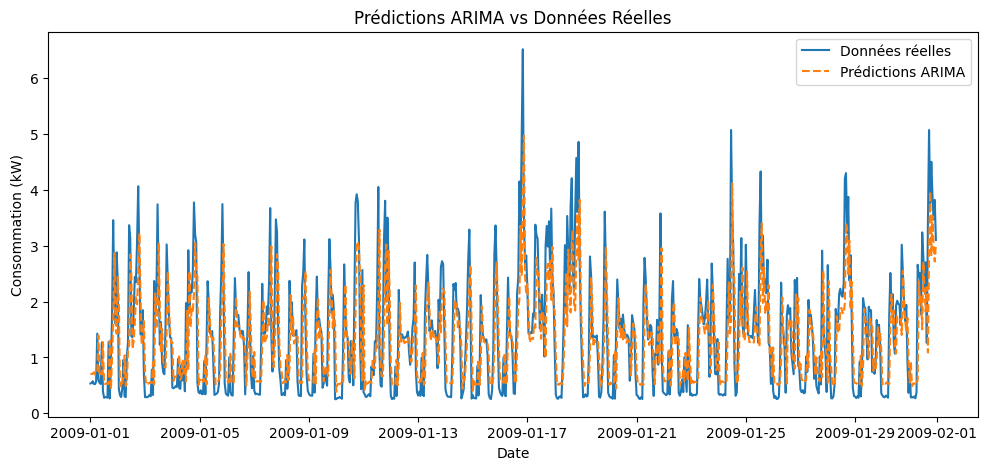

In [55]:
# Prédictions avec index correct

df.loc[:, 'forecast'] = model_fit.predict(start=df.index[0], end=df.index[-1])
df_janvier_2009 = df.loc["2009-01-01":"2009-01-31"].copy()


# Visualisation
plt.figure(figsize=(12,5))
plt.plot(df_janvier_2009['Global_active_power'], label="Données réelles")
plt.plot(df_janvier_2009['forecast'], label="Prédictions ARIMA", linestyle="dashed")
plt.title("Prédictions ARIMA vs Données Réelles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()
plt.show()

# Analyse du Graphique : Prédictions ARIMA vs Données Réelles (Janvier 2009)

L’image représente les **prédictions du modèle ARIMA** comparées aux **données réelles de consommation d’énergie** sur le mois de **janvier 2009**.


- ***Précision du Modèle***
    - **Les prédictions suivent globalement la tendance des données réelles**, indiquant que le modèle **captive bien les fluctuations de consommation**.  
    - **Le modèle réussit à suivre les pics et les creux**, bien que **certains écarts persistent**.


- ***Variabilité Temporelle***
    - **Le modèle capture les cycles journaliers de consommation**, montrant **une corrélation avec les variations horaires d’utilisation d’électricité**.  
    - **Cependant, certains pics sont sous-estimés ou surestimés**, ce qui **pourrait être amélioré en intégrant une meilleure prise en compte de la saisonnalité**.  


# Évaluation du Modèle SARIMA

Une fois le modèle entraîné, nous pouvons utiliser plusieurs **métriques** pour juger de sa pertinence :


- ***Erreur Absolue Moyenne (MAE)***

    L'**Erreur Absolue Moyenne** (**MAE**) mesure l'écart moyen absolu entre les **prédictions** et les **valeurs réelles** :

    $$
    MAE = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
    $$

    
    - **MAE faible** → Le modèle **prédit des valeurs proches des données réelles**.  
    - **MAE élevé** → Il y a **des écarts importants en moyenne** entre les prédictions et la réalité.


- ***Erreur Quadratique Moyenne (RMSE)***

    L'**Erreur Quadratique Moyenne** (**RMSE**) est une **mesure plus sensible aux grandes erreurs** :

    $$
    RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2}
    $$

    - **Le RMSE pénalise davantage les grandes erreurs**, ce qui permet de détecter si **le modèle est imprécis sur certaines valeurs extrêmes**.  
    - **Un RMSE proche du MAE** indique que **les erreurs sont bien réparties** et qu'il n'y a **pas de grandes erreurs isolées**.  

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(df['Global_active_power'], df['forecast'])
print(f"MAE: {mae}")

rmse = np.sqrt(mean_squared_error(df['Global_active_power'], df['forecast']))
print(f"RMSE: {rmse}")

MAE: 0.44539429799237845
RMSE: 0.6233558803254842


# **Évaluation des Performances du Modèle ARIMA**

Après l'entraînement du modèle, nous avons calculé les **métriques d'erreur** suivantes :

- ***Erreur Absolue Moyenne (MAE)***

    - **Le MAE indique que, en moyenne, les prévisions du modèle ARIMA s'écartent de 0.4454 kW des valeurs réelles.**  
    - **Un MAE faible** signifie que **le modèle est globalement précis**.


- ***Erreur Quadratique Moyenne (RMSE)***

    L'**Erreur Quadratique Moyenne** (**RMSE**) est définie comme suit :

    - **Le RMSE est plus sensible aux grandes erreurs** : la valeur de **0.6234 kW** suggère que **certaines prévisions présentent des écarts plus importants**.  
    - **Un RMSE supérieur au MAE** indique **que le modèle peine davantage à prédire les pics de consommation**.

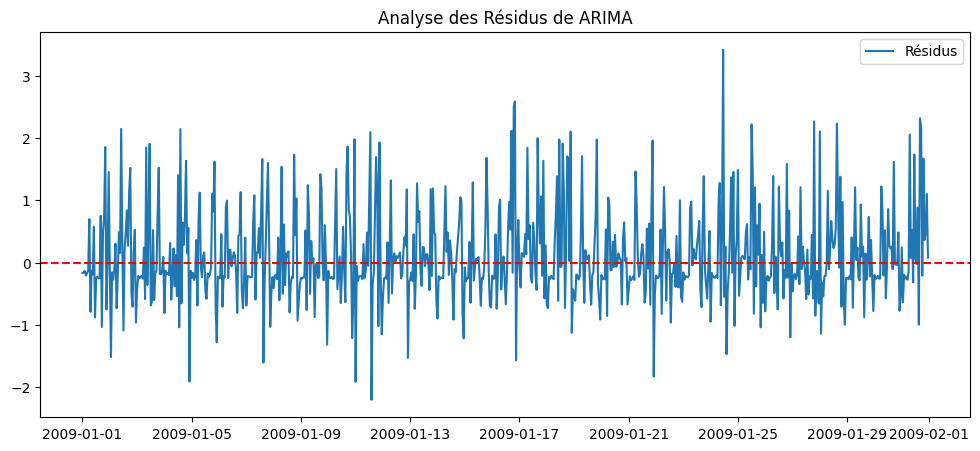

In [57]:
residuals = df_janvier_2009['Global_active_power'] - df_janvier_2009['forecast']
plt.figure(figsize=(12, 5))
plt.plot(df_janvier_2009.index, residuals, label="Résidus")
plt.axhline(0, linestyle='dashed', color='red')
plt.legend()
plt.title("Analyse des Résidus de ARIMA")
plt.show()


# **Analyse des Résidus du Modèle ARIMA**

L’image montre **l’analyse des résidus du modèle ARIMA** appliqué à la **consommation d’énergie** en **janvier 2009**.

- ***Centrage autour de zéro***
    - **Les résidus fluctuent autour de la ligne rouge (moyenne nulle)**, ce qui est un bon indicateur que **le modèle ne présente pas de biais systématique**.  

- ***Présence de motifs dans les erreurs***  
    - **Une dispersion irrégulière est visible**, notamment avec **des pics importants**, indiquant que **le modèle ne capture pas parfaitement toutes les dynamiques de la série**.  
    - **Certains pics soudains de résidus** montrent **des erreurs plus marquées à certains moments**, suggérant que **des événements non modélisés influencent les prédictions**.

- ***Hétéroscédasticité potentielle***
    - **L’intensité des résidus semble varier par périodes**, ce qui pourrait **indiquer une variance non constante**.  
    - **Ce phénomène pourrait être mieux géré en intégrant un modèle GARCH** ou en **appliquant une transformation logarithmique aux données**.


   Global_active_power  Global_reactive_power  Voltage  Global_intensity  \
0                4.216                  0.418   234.84              18.4   
1                5.360                  0.436   233.63              23.0   
2                5.374                  0.498   233.29              23.0   
3                5.388                  0.502   233.74              23.0   
4                3.666                  0.528   235.68              15.8   

   Sub_metering_1  Sub_metering_2  Sub_metering_3            datetime  
0             0.0             1.0            17.0 2006-12-16 17:24:00  
1             0.0             1.0            16.0 2006-12-16 17:25:00  
2             0.0             2.0            17.0 2006-12-16 17:26:00  
3             0.0             1.0            17.0 2006-12-16 17:27:00  
4             0.0             1.0            17.0 2006-12-16 17:28:00  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns)

/home/kd/anaconda3/envs/sep24_cv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/home/kd/anaconda3/envs/sep24_cv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.73979D-01    |proj g|=  3.92898D-01

At iterate    5    f=  4.99281D-01    |proj g|=  5.74329D-02

At iterate   10    f=  4.94258D-01    |proj g|=  4.60944D-02

At iterate   15    f=  4.91396D-01    |proj g|=  7.99359D-03

At iterate   20    f=  4.90774D-01    |proj g|=  9.00425D-03

At iterate   25    f=  4.90726D-01    |proj g|=  1.67562D-03

At iterate   30    f=  4.90704D-01    |proj g|=  4.89221D-03

At iterate   35    f=  4.90638D-01    |proj g|=  9.59091D-04

At iterate   40    f=  4.90636D-01    |proj g|=  4.05905D-04

At iterate   45    f=  4.90636D-01    |proj g|=  2.89176D-05

At iterate   50    f=  4.90636D-01    |proj g|=  3.18753D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/kd/anaconda3/envs/sep24_cv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                  Global_active_power   No. Observations:                50000
Model:             SARIMAX(5, 0, 2)x(1, 0, [1], 24)   Log Likelihood              -24531.790
Date:                              Sat, 22 Feb 2025   AIC                          49083.579
Time:                                      23:27:12   BIC                          49171.777
Sample:                                  12-16-2006   HQIC                         49111.207
                                       - 01-20-2007                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7191      0.007    107.298      0.000       0.706       0.732
ar.L2         -0.57

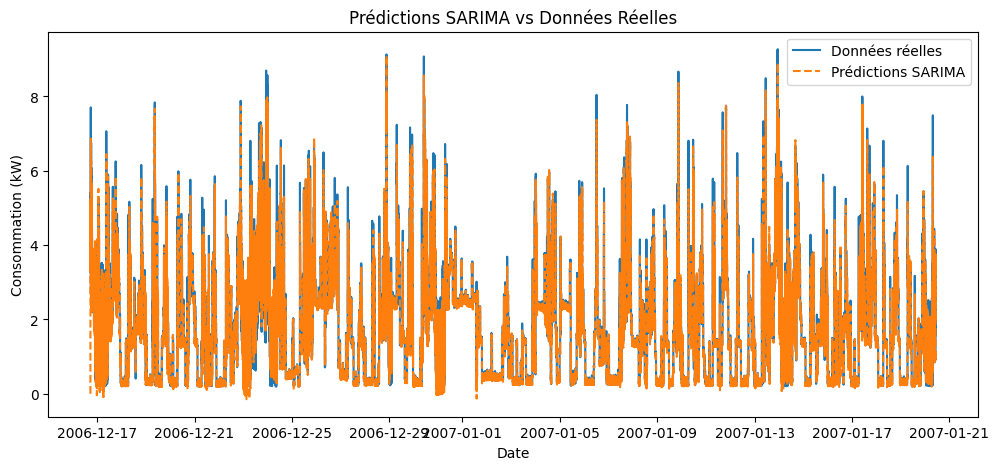

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Définition du modèle SARIMA
model_sarima = SARIMAX(df_sample['Global_active_power'],
                        order=(1,0,1), 
                        seasonal_order=(1,0,1,24))

# Entraînement du modèle
model_fit_sarima = model_sarima.fit()

# Afficher le résumé du modèle
model_fit_sarima.summary()



In [ ]:
# Prédictions avec index correct
df_sample['forecast_sarima'] = model_fit_sarima.predict(start=df_sample.index[0], end=df_sample.index[-1])

# 📈 Comparaison des prédictions SARIMA vs données réelles
plt.figure(figsize=(12,5))
plt.plot(df_sample['Global_active_power'], label="Données réelles")
plt.plot(df_sample['forecast_sarima'], label="Prédictions SARIMA", linestyle="dashed")
plt.title("Prédictions SARIMA vs Données Réelles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()
plt.show()

Fréquence détectée : <Hour>


/home/kd/anaconda3/envs/sep24_cv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/kd/anaconda3/envs/sep24_cv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33271D+00    |proj g|=  1.20684D+00


 This problem is unconstrained.



At iterate    5    f=  8.98142D-01    |proj g|=  6.53065D-02

At iterate   10    f=  8.82313D-01    |proj g|=  3.07821D-02

At iterate   15    f=  8.52237D-01    |proj g|=  7.70112D-02

At iterate   20    f=  8.48676D-01    |proj g|=  3.60152D-03

At iterate   25    f=  8.47511D-01    |proj g|=  1.07519D-02

At iterate   30    f=  8.47248D-01    |proj g|=  1.15362D-03

At iterate   35    f=  8.47242D-01    |proj g|=  1.02936D-04

At iterate   40    f=  8.47237D-01    |proj g|=  1.84655D-03

At iterate   45    f=  8.47196D-01    |proj g|=  1.36849D-03


/home/kd/anaconda3/envs/sep24_cv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.47190D-01    |proj g|=  4.96045D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   4.960D-05   8.472D-01
  F =  0.84719020089021924     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                       
Dep. Variable:                  Global_active_power   No. Observations:                34589
Model:             SARIMAX(5, 0, 2)x(1, 0, [1], 24)   Log Likelihood              -29303.462
Date:                              Sat, 22 Feb 2025   AIC                         

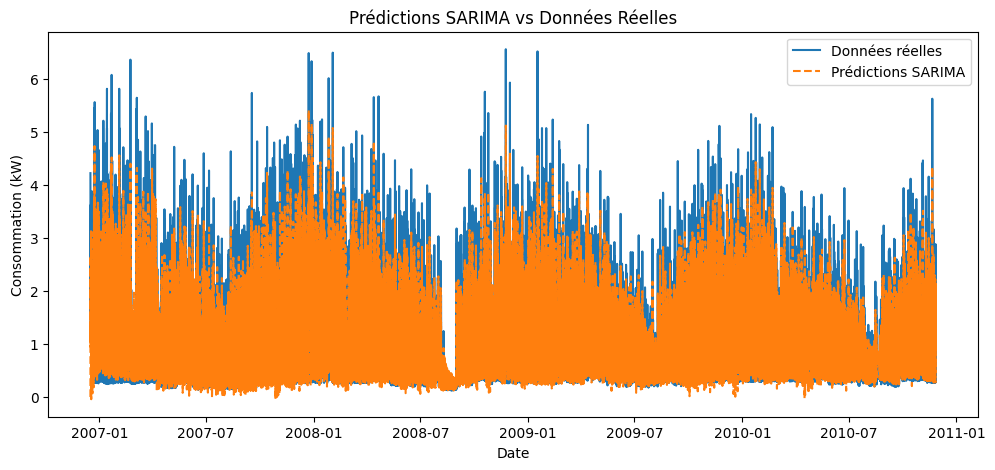

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Vérifier et convertir datetime en index
if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

# Vérifier et définir une fréquence correcte
if df.index.freq is None:
    df = df.resample('h').mean().interpolate()

print("Fréquence détectée :", df.index.freq)

# Réduire la taille des données
df_sample = df.iloc[:50_000].copy()  # Ajout de .copy() pour éviter SettingWithCopyWarning

# Définir et entraîner le modèle SARIMA
model = SARIMAX(df_sample['Global_active_power'], order=(5, 0, 2), seasonal_order=(1, 0, 1, 24))
model_fit = model.fit()

# Afficher le résumé du modèle
print(model_fit.summary())

# Prédictions avec index correct
df_sample.loc[:, 'forecast'] = model_fit.predict(start=df_sample.index[0], end=df_sample.index[-1])

# 📈 Visualisation des Prédictions
plt.figure(figsize=(12,5))
plt.plot(df_sample['Global_active_power'], label="Données réelles")
plt.plot(df_sample['forecast'], label="Prédictions SARIMA", linestyle="dashed")
plt.title("Prédictions SARIMA vs Données Réelles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()
plt.show()


📊 Entraînement du modèle SARIMA...


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75073D-01    |proj g|=  4.55148D-01

At iterate    5    f=  8.64776D-01    |proj g|=  1.83981D-01

At iterate   10    f=  8.46473D-01    |proj g|=  4.56285D-03

At iterate   15    f=  8.46428D-01    |proj g|=  5.73965D-05

At iterate   20    f=  8.46427D-01    |proj g|=  7.21382D-04

At iterate   25    f=  8.46417D-01    |proj g|=  2.11705D-03

At iterate   30    f=  8.46402D-01    |proj g|=  3.45065D-03

At iterate   35    f=  8.46396D-01    |proj g|=  2.73871D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


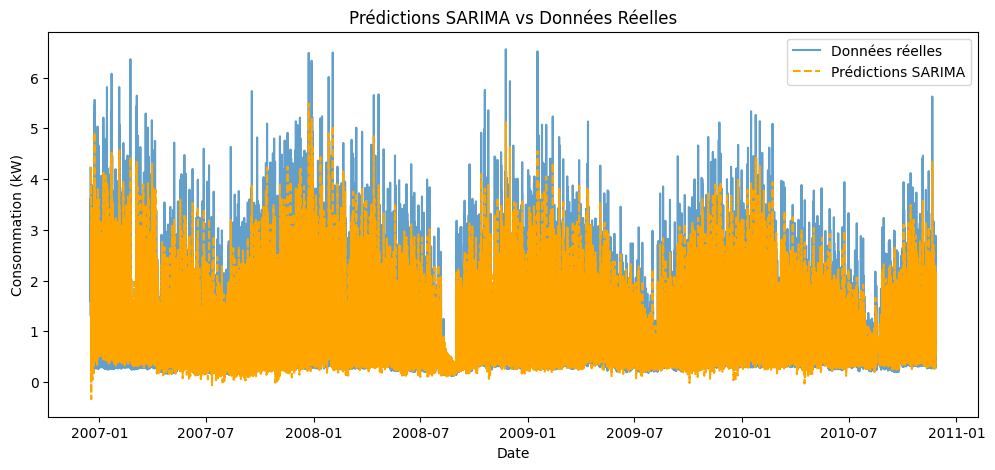


📊 Entraînement du modèle ARIMA...


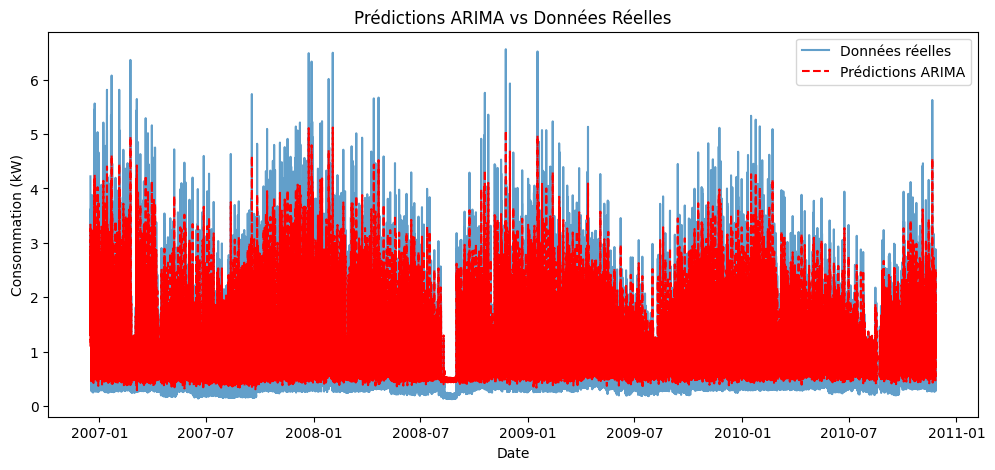

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 📌 Vérification de datetime en index
df_sample = df_sample.copy()  # Éviter les erreurs de modification

if 'datetime' in df_sample.columns:
    df_sample['datetime'] = pd.to_datetime(df_sample['datetime'])
    df_sample.set_index('datetime', inplace=True)

# 📌 Vérification fréquence des données
if df_sample.index.freq is None:
    df_sample = df_sample.asfreq('h')  # Rééchantillonnage horaire

# ✅ 📌 Prédiction avec SARIMA
print("📊 Entraînement du modèle SARIMA...")
model_sarima = SARIMAX(df_sample['Global_active_power'], order=(5, 0, 2), seasonal_order=(1, 1, 1, 24))
model_fit_sarima = model_sarima.fit()
df_sample['forecast_sarima'] = model_fit_sarima.predict(start=df_sample.index[0], end=df_sample.index[-1])

# 📈 Visualisation des Prédictions SARIMA
plt.figure(figsize=(12,5))
plt.plot(df_sample['Global_active_power'], label="Données réelles", alpha=0.7)
plt.plot(df_sample['forecast_sarima'], label="Prédictions SARIMA", linestyle="dashed", color='orange')
plt.title("Prédictions SARIMA vs Données Réelles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()
plt.show()


# ✅ 📌 Prédiction avec ARIMA
print("\n📊 Entraînement du modèle ARIMA...")
model_arima = ARIMA(df_sample['Global_active_power'], order=(3, 0, 1))
model_fit_arima = model_arima.fit()
df_sample['forecast_arima'] = model_fit_arima.predict(start=df_sample.index[0], end=df_sample.index[-1])

# 📈 Visualisation des Prédictions ARIMA
plt.figure(figsize=(12,5))
plt.plot(df_sample['Global_active_power'], label="Données réelles", alpha=0.7)
plt.plot(df_sample['forecast_arima'], label="Prédictions ARIMA", linestyle="dashed", color='red')
plt.title("Prédictions ARIMA vs Données Réelles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()
plt.show()



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Charger les données
df = read_file(file_path)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Vérifier et corriger la fréquence
if df.index.freq is None:
    df = df.resample('h').mean().interpolate()

# Normalisation des données pour LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['Global_active_power']])

# Définir la fonction pour créer des séquences temporelles
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i: i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Définition des paramètres
time_steps = 24  # Utiliser les 24 dernières heures pour prédire la suivante

# Séparation en train/test (80% train, 20% test)
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Création des séquences temporelles
X_train, y_train = create_sequences(train, time_steps)
X_test, y_test = create_sequences(test, time_steps)

# Reshape pour être compatible avec LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Shape de X_train :", X_train.shape)
print("Shape de X_test :", X_test.shape)


   Global_active_power  Global_reactive_power  Voltage  Global_intensity  \
0                4.216                  0.418   234.84              18.4   
1                5.360                  0.436   233.63              23.0   
2                5.374                  0.498   233.29              23.0   
3                5.388                  0.502   233.74              23.0   
4                3.666                  0.528   235.68              15.8   

   Sub_metering_1  Sub_metering_2  Sub_metering_3            datetime  
0             0.0             1.0            17.0 2006-12-16 17:24:00  
1             0.0             1.0            16.0 2006-12-16 17:25:00  
2             0.0             2.0            17.0 2006-12-16 17:26:00  
3             0.0             1.0            17.0 2006-12-16 17:27:00  
4             0.0             1.0            17.0 2006-12-16 17:28:00  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns)

In [ ]:
# Définition du modèle LSTM
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20


/home/kd/anaconda3/envs/sep24_cv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0170 - val_loss: 0.0066
Epoch 2/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0100 - val_loss: 0.0064
Epoch 3/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0096 - val_loss: 0.0064
Epoch 4/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0093 - val_loss: 0.0062
Epoch 5/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0091 - val_loss: 0.0063
Epoch 6/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0092 - val_loss: 0.0062
Epoch 7/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0090 - val_loss: 0.0061
Epoch 8/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0089 - val_loss: 0.0061
Epoch 9/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0089 - val_loss: 0.0060
Epoch 10/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0084 - val_loss: 0.0060
Epoch 11/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0087 - val_loss: 0.0062
Epoch 12/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0

In [ ]:
# Prédictions avec LSTM
y_pred_lstm = model.predict(X_test)

# Dénormaliser les prédictions
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Ajouter au DataFrame pour comparer
df_results = pd.DataFrame({
    'Date': df.index[-len(y_test):],
    'Réel': y_test.flatten(),
    'Prédiction LSTM': y_pred_lstm.flatten(),
    'Prédiction ARIMA': df_sample['forecast'].iloc[-len(y_test):].values,
    'Prédiction SARIMA': df_sample['forecast_sarima'].iloc[-len(y_test):].values
}).set_index('Date')

print(df_results.head())


216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
                          Réel  Prédiction LSTM  Prédiction ARIMA  \
Date                                                                
2010-02-12 16:00:00   9.591926         1.641613          1.320388   
2010-02-12 17:00:00   5.101800         1.893013          1.347380   
2010-02-12 18:00:00   4.707455         1.228478          0.806478   
2010-02-12 19:00:00   7.571927         1.261032          0.802965   
2010-02-12 20:00:00  13.760440         1.585716          1.166895   

                     Prédiction SARIMA  
Date                                    
2010-02-12 16:00:00           1.292351  
2010-02-12 17:00:00           1.626310  
2010-02-12 18:00:00           1.641237  
2010-02-12 19:00:00           1.760024  
2010-02-12 20:00:00           1.622554  


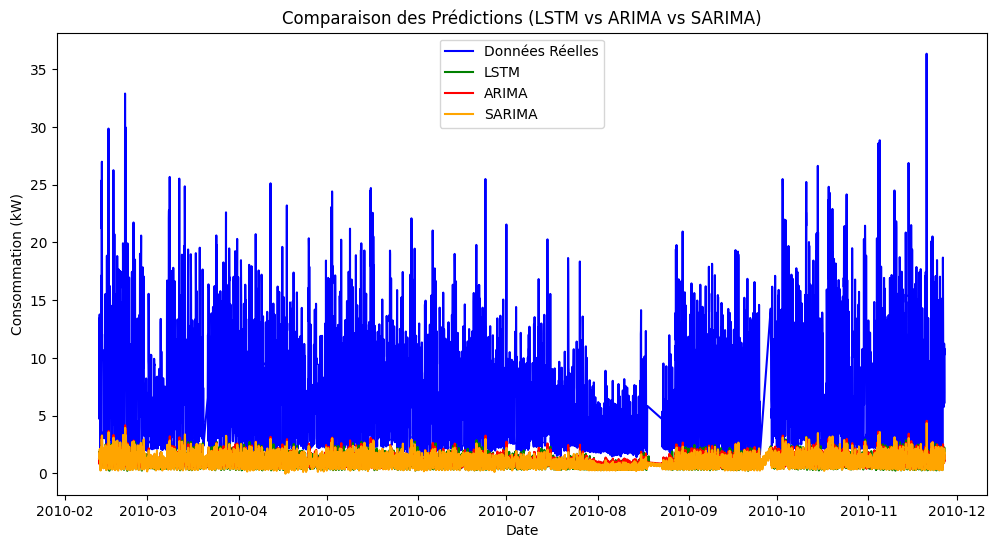

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_results, x='Date', y='Réel', label='Données Réelles', color='blue')
sns.lineplot(data=df_results, x='Date', y='Prédiction LSTM', label='LSTM', color='green')
sns.lineplot(data=df_results, x='Date', y='Prédiction ARIMA', label='ARIMA', color='red')
sns.lineplot(data=df_results, x='Date', y='Prédiction SARIMA', label='SARIMA', color='orange')
plt.title("Comparaison des Prédictions (LSTM vs ARIMA vs SARIMA)")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
rmse_arima = np.sqrt(mean_squared_error(y_test, df_sample['forecast'].iloc[-len(y_test):].values))
rmse_sarima = np.sqrt(mean_squared_error(y_test, df_sample['forecast_sarima'].iloc[-len(y_test):].values))

print(f" RMSE LSTM : {rmse_lstm:.4f}")
print(f" RMSE ARIMA : {rmse_arima:.4f}")
print(f" RMSE SARIMA : {rmse_sarima:.4f}")


 RMSE LSTM : 6.9525
 RMSE ARIMA : 7.0404
 RMSE SARIMA : 7.0170


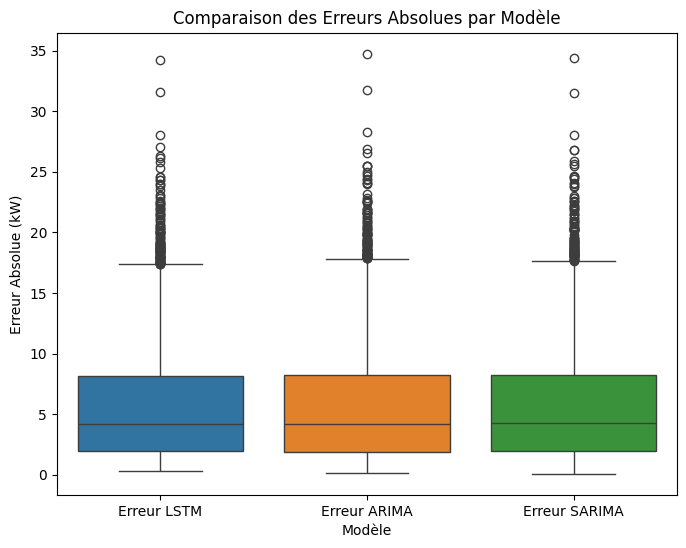

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des erreurs absolues
df_results["Erreur LSTM"] = abs(df_results["Réel"] - df_results["Prédiction LSTM"])
df_results["Erreur ARIMA"] = abs(df_results["Réel"] - df_results["Prédiction ARIMA"])
df_results["Erreur SARIMA"] = abs(df_results["Réel"] - df_results["Prédiction SARIMA"])

# Visualisation en boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_results[["Erreur LSTM", "Erreur ARIMA", "Erreur SARIMA"]])
plt.title("Comparaison des Erreurs Absolues par Modèle")
plt.ylabel("Erreur Absolue (kW)")
plt.xlabel("Modèle")
plt.show()


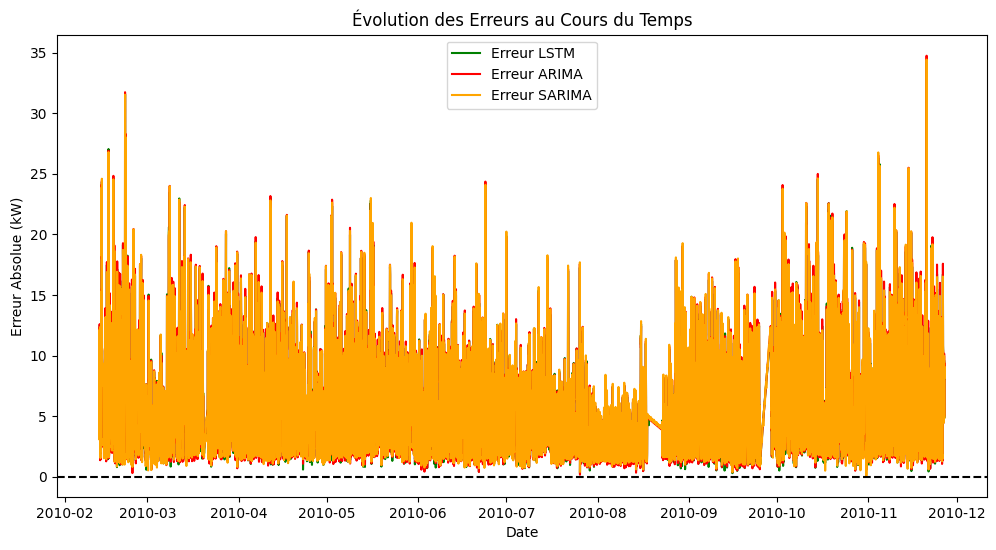

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_results, x='Date', y="Erreur LSTM", label="Erreur LSTM", color="green")
sns.lineplot(data=df_results, x='Date', y="Erreur ARIMA", label="Erreur ARIMA", color="red")
sns.lineplot(data=df_results, x='Date', y="Erreur SARIMA", label="Erreur SARIMA", color="orange")
plt.axhline(0, linestyle="dashed", color="black")  # Ligne à zéro pour référence
plt.title("Évolution des Erreurs au Cours du Temps")
plt.ylabel("Erreur Absolue (kW)")
plt.xlabel("Date")
plt.legend()
plt.show()


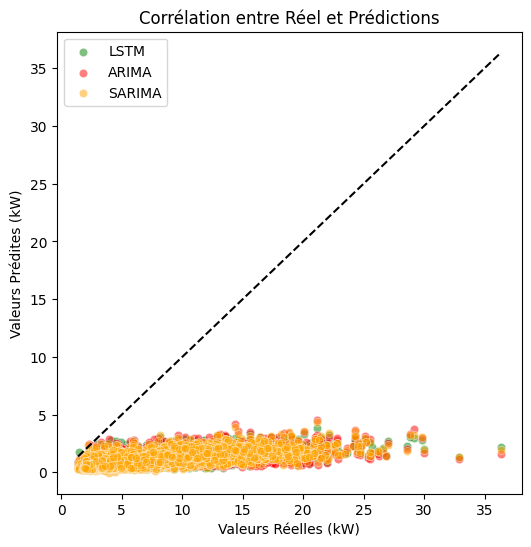

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=df_results["Réel"], y=df_results["Prédiction LSTM"], label="LSTM", color="green", alpha=0.5)
sns.scatterplot(x=df_results["Réel"], y=df_results["Prédiction ARIMA"], label="ARIMA", color="red", alpha=0.5)
sns.scatterplot(x=df_results["Réel"], y=df_results["Prédiction SARIMA"], label="SARIMA", color="orange", alpha=0.5)
plt.plot([df_results["Réel"].min(), df_results["Réel"].max()], 
         [df_results["Réel"].min(), df_results["Réel"].max()], color="black", linestyle="dashed")  # Diagonale idéale
plt.xlabel("Valeurs Réelles (kW)")
plt.ylabel("Valeurs Prédites (kW)")
plt.title("Corrélation entre Réel et Prédictions")
plt.legend()
plt.show()


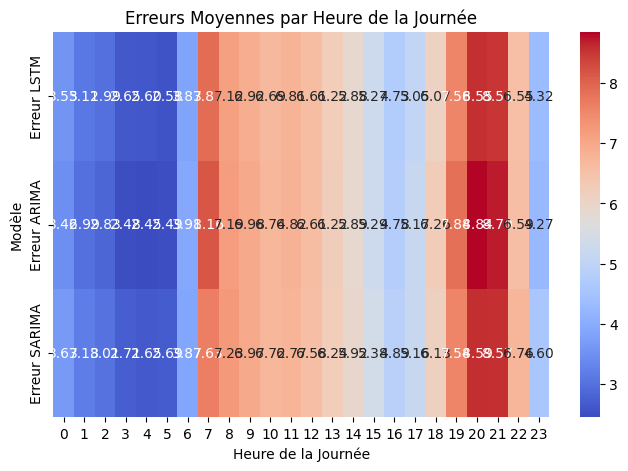

In [ ]:
df_results["Heure"] = df_results.index.hour  # Extraire l'heure de la journée
df_errors = df_results.groupby("Heure")[["Erreur LSTM", "Erreur ARIMA", "Erreur SARIMA"]].mean()

plt.figure(figsize=(8, 5))
sns.heatmap(df_errors.T, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Erreurs Moyennes par Heure de la Journée")
plt.xlabel("Heure de la Journée")
plt.ylabel("Modèle")
plt.show()


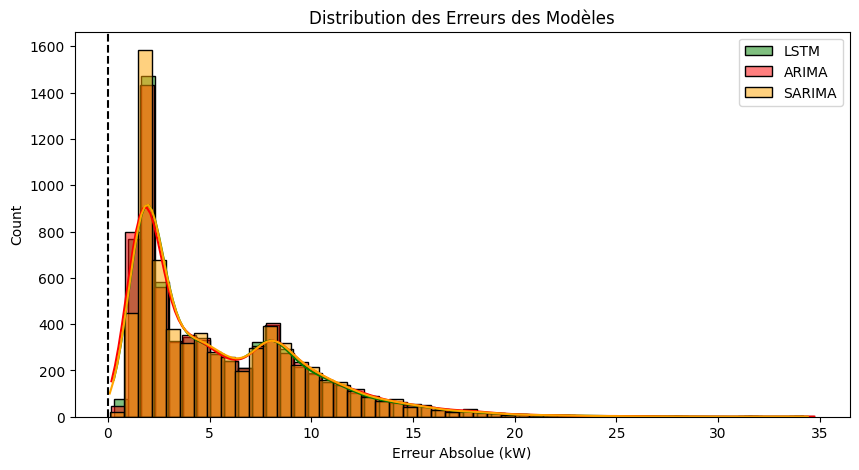

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df_results["Erreur LSTM"], bins=50, label="LSTM", color="green", kde=True)
sns.histplot(df_results["Erreur ARIMA"], bins=50, label="ARIMA", color="red", kde=True)
sns.histplot(df_results["Erreur SARIMA"], bins=50, label="SARIMA", color="orange", kde=True)
plt.axvline(0, linestyle="dashed", color="black")  # Ligne zéro pour référence
plt.xlabel("Erreur Absolue (kW)")
plt.title("Distribution des Erreurs des Modèles")
plt.legend()
plt.show()
